In [0]:
import numpy as np
import torch
import torch.optim as optim

In [3]:
pip install adabound


In [0]:
import adabound

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

def rastrigin(A,x):
    n = x.shape[0]
    return A*n + x[0]**2 + x[1]**2 - A*torch.cos(2*np.pi*x[0]) - A*torch.cos(2*np.pi*x[1])




xmin, xmax, xstep = -5, 5, .1
ymin, ymax, ystep = -5, 5, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastrigin(10,torch.tensor([x, y])).numpy()
              
z

array([[50.        , 50.91983006, 54.94983006, ..., 54.94983006,
        50.91983006, 50.        ],
       [50.91983006, 51.83966011, 55.86966011, ..., 55.86966011,
        51.83966011, 50.91983006],
       [54.94983006, 55.86966011, 59.89966011, ..., 59.89966011,
        55.86966011, 54.94983006],
       ...,
       [54.94983006, 55.86966011, 59.89966011, ..., 59.89966011,
        55.86966011, 54.94983006],
       [50.91983006, 51.83966011, 55.86966011, ..., 55.86966011,
        51.83966011, 50.91983006],
       [50.        , 50.91983006, 54.94983006, ..., 54.94983006,
        50.91983006, 50.        ]])

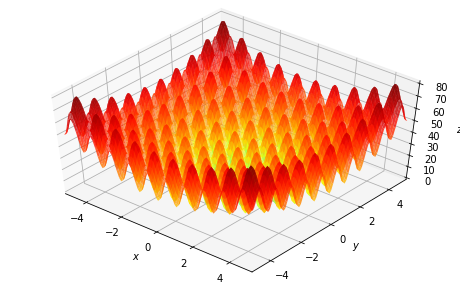

In [5]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [0]:
xmin, xmax, xstep = -5.12, 5.12, .1
ymin, ymax, ystep = -5.12, 5.12, .1
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastrigin(10,torch.tensor([x, y])).numpy() 

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


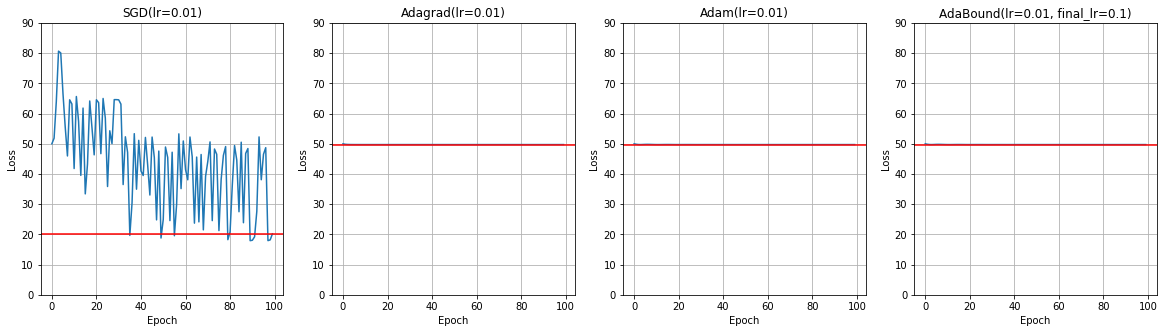

In [7]:
fig, ax = plt.subplots(ncols=4,figsize=(20,5))
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opts = [optim.SGD([p], lr=0.01),
       optim.Adagrad([p], lr=0.01),
       optim.Adam([p], lr=0.01),
        adabound.AdaBound([p], lr=0.01, final_lr=0.1)
       ]
names = ['SGD(lr=0.01)','Adagrad(lr=0.01)','Adam(lr=0.01)','AdaBound(lr=0.01, final_lr=0.1)']

j=0
for opt in opts:
    p.data = torch.tensor([[5.0],[5.0]])
    path = np.empty((2,0))
    path = np.append(path, p.data.numpy(), axis=1)
    lPlot = np.empty((1,0))
  
    for i in range(100):
        opt.zero_grad()
        output = rastrigin(10,p)
        output.backward()
        opt.step()
        path = np.append(path, p.data.numpy(), axis=1)
        lPlot = np.append(lPlot, output.data.numpy().reshape(1,-1), axis=1)
    ax[j].plot(range(100),lPlot.squeeze())#,label=str(opt)
    ax[j].set_title(names[j])
    ax[j].set_ylim(0,90)
    ax[j].grid(True)
    ax[j].set_ylabel("Loss")
    ax[j].set_xlabel("Epoch")
    ax[j].axhline(y=lPlot[:,-1].item(), color='r')
    j+=1
    


# SVM on Iris dataset

In [0]:
# define our hinge loss
def hinge_loss(y_pred, y_true):
    p = torch.zeros(y_pred.shape)
    r = torch.max(p,(1 - y_pred.float() * y_true.float()))
    return r.mean().float()

#  define our support vector machine
def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h
import pandas as pd


In [0]:
# load data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None )
df = df.sample(frac =1, random_state =0) #shuffle
# add labelindices column
df = df[df[4].isin(['Iris-virginica','Iris-versicolor'])] # filter

# add labelindicescolumn
mapping = {k : v for v, k in enumerate( df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1 #labels in {−1 ,1}


# normalisedata
alldata = torch.tensor(df.iloc[:,[0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata-alldata.mean (dim=0)) / alldata.var(dim=0) 
# # dim = 0 对各列进行操作

#createdatasets
targetstr = torch.tensor(df.iloc[:75,5].values, dtype=torch.long )
targetsva = torch.tensor(df.iloc[75:,5].values, dtype=torch.long )
datatr = alldata[:75]
datava = alldata[75:]


In [0]:
# Build up our dataloader from raw data
from torch.utils import data
dataset = data.TensorDataset(datatr,targetstr) 
dataloader = data.DataLoader(dataset, batch_size=25, shuffle=True) # create your dataloader

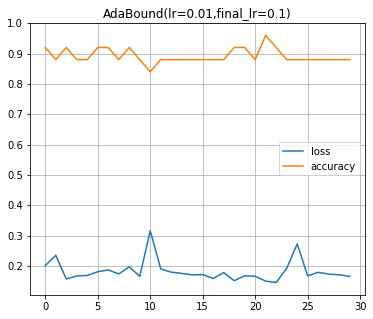

In [14]:
ws=[0 for _ in range(30)]
bs=[0 for _ in range(30)]
torch.manual_seed(9702)
for i in range(30):
  ws[i] = torch.randn(1, 4, requires_grad=True)
  bs[i] = torch.randn(1, requires_grad=True)
trPlot = []
vaPlot = []
for i in range(30):
  w = ws[i]
  b = bs[i]
  opt = adabound.AdaBound([w,b], lr=0.01, final_lr=0.1)
  for epoch in range(100):
      for batch in dataloader:
          opt.zero_grad()
          output = svm(batch[0],w,b)
          loss = hinge_loss(output, batch[1])
          loss.backward()
          opt.step()      
      
  # Compute prediction loss on validation set
  output = svm(datava,w,b)
  loss = hinge_loss(output,targetsva)

  # Compute classification accuracy

  target = datava @ w.t() + b
  pred_y = target.data.numpy()

  for i in range (len(target)):
      if(pred_y[i][0]) <= 0:
          pred_y[i][0] = -1
      else:
          pred_y[i][0] = 1
          
  target_y = targetsva.data.numpy()
  target = datava @ w.t() + b
  var_y = target.data.numpy()

  accuracy = 0
  for i in range (len(pred_y)):
      if(pred_y[i]) == target_y[i]:
          accuracy += 1
      else:
          continue

  trPlot.append(loss.data.numpy())
  vaPlot.append(accuracy/25)
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(30),trPlot,label='loss'),ax.plot(range(30),vaPlot,label='accuracy')
ax.set_title('AdaBound(lr=0.01,final_lr=0.1)')
ax.legend()
ax.grid(True)

In [0]:
adabound_loss =  trPlot
adabound_accuracy  = vaPlot

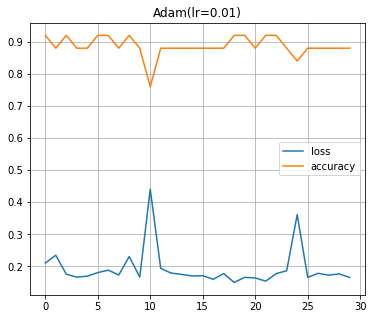

In [17]:
ws=[0 for _ in range(30)]
bs=[0 for _ in range(30)]
torch.manual_seed(9702)
for i in range(30):
  ws[i] = torch.randn(1, 4, requires_grad=True)
  bs[i] = torch.randn(1, requires_grad=True)


trPlot = []
vaPlot = []
for i in range(30):
  w = ws[i]
  b = bs[i]
  opt = optim.Adam([w,b], lr=0.01)
  for epoch in range(100):
      for batch in dataloader:
          opt.zero_grad()
          output = svm(batch[0],w,b)
          loss = hinge_loss(output, batch[1])
          loss.backward()
          opt.step()      
      
  # Compute prediction loss on validation set
  output = svm(datava,w,b)
  loss = hinge_loss(output,targetsva)

  # Compute classification accuracy

  target = datava @ w.t() + b
  pred_y = target.data.numpy()

  for i in range (len(target)):
      if(pred_y[i][0]) <= 0:
          pred_y[i][0] = -1
      else:
          pred_y[i][0] = 1
          
  target_y = targetsva.data.numpy()
  target = datava @ w.t() + b
  var_y = target.data.numpy()

  accuracy = 0
  for i in range (len(pred_y)):
      if(pred_y[i]) == target_y[i]:
          accuracy += 1
      else:
          continue

  trPlot.append(loss.data.numpy())
  vaPlot.append(accuracy/25)
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(30),trPlot,label='loss'),ax.plot(range(30),vaPlot,label='accuracy')
ax.set_title('Adam(lr=0.01)')
ax.legend()
ax.grid(True)

In [0]:
Adam_loss =  trPlot
Adam_accuracy  = vaPlot

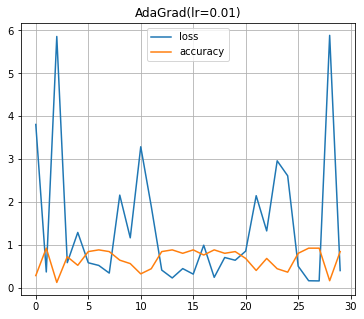

In [19]:
ws=[0 for _ in range(30)]
bs=[0 for _ in range(30)]
torch.manual_seed(9702)
for i in range(30):
  ws[i] = torch.randn(1, 4, requires_grad=True)
  bs[i] = torch.randn(1, requires_grad=True)


trPlot = []
vaPlot = []
for i in range(30):
  w = ws[i]
  b = bs[i]
  opt = optim.Adagrad([w,b], lr=0.01, weight_decay=0.0001)
  for epoch in range(100):
      for batch in dataloader:
          opt.zero_grad()
          output = svm(batch[0],w,b)
          loss = hinge_loss(output, batch[1])
          loss.backward()
          opt.step()      
      
  # Compute prediction loss on validation set
  output = svm(datava,w,b)
  loss = hinge_loss(output,targetsva)

  # Compute classification accuracy

  target = datava @ w.t() + b
  pred_y = target.data.numpy()

  for i in range (len(target)):
      if(pred_y[i][0]) <= 0:
          pred_y[i][0] = -1
      else:
          pred_y[i][0] = 1
          
  target_y = targetsva.data.numpy()
  target = datava @ w.t() + b
  var_y = target.data.numpy()

  accuracy = 0
  for i in range (len(pred_y)):
      if(pred_y[i]) == target_y[i]:
          accuracy += 1
      else:
          continue

  trPlot.append(loss.data.numpy())
  vaPlot.append(accuracy/25)
fig,ax = plt.subplots(figsize=(6,5))
ax.set_title('AdaGrad(lr=0.01)')
ax.plot(range(30),trPlot,label='loss'),ax.plot(range(30),vaPlot,label='accuracy')
ax.legend()
ax.grid(True)

In [0]:
Adam_loss =  trPlot
Adam_accuracy  = vaPlot

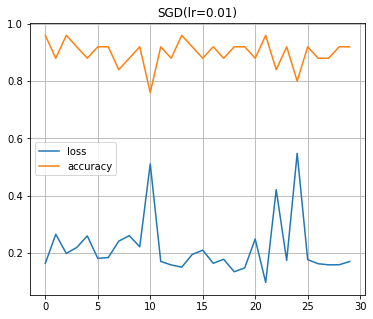

In [21]:
ws=[0 for _ in range(30)]
bs=[0 for _ in range(30)]
torch.manual_seed(9702)
for i in range(30):
  ws[i] = torch.randn(1, 4, requires_grad=True)
  bs[i] = torch.randn(1, requires_grad=True)


trPlot = []
vaPlot = []
for i in range(30):
  w = ws[i]
  b = bs[i]
  opt = optim.SGD([w,b], lr=0.01)
  for epoch in range(100):
      for batch in dataloader:
          opt.zero_grad()
          output = svm(batch[0],w,b)
          loss = hinge_loss(output, batch[1])
          loss.backward()
          opt.step()      
      
  # Compute prediction loss on validation set
  output = svm(datava,w,b)
  loss = hinge_loss(output,targetsva)

  # Compute classification accuracy

  target = datava @ w.t() + b
  pred_y = target.data.numpy()

  for i in range (len(target)):
      if(pred_y[i][0]) <= 0:
          pred_y[i][0] = -1
      else:
          pred_y[i][0] = 1
          
  target_y = targetsva.data.numpy()
  target = datava @ w.t() + b
  var_y = target.data.numpy()

  accuracy = 0
  for i in range (len(pred_y)):
      if(pred_y[i]) == target_y[i]:
          accuracy += 1
      else:
          continue

  trPlot.append(loss.data.numpy())
  vaPlot.append(accuracy/25)
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(30),trPlot,label='loss'),ax.plot(range(30),vaPlot,label='accuracy')
ax.set_title('SGD(lr=0.01)')
ax.legend()
ax.grid(True)

In [0]:
SGD_loss =  trPlot
SGD_accuracy  = vaPlot

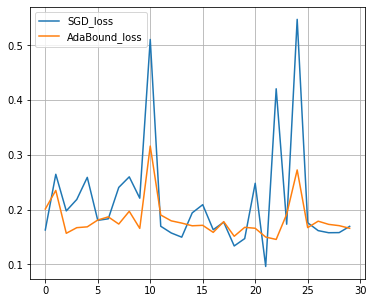

In [24]:
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(30),SGD_loss,label='SGD_loss'),ax.plot(range(30),adabound_loss,label='AdaBound_loss')
ax.legend()
ax.grid(True)

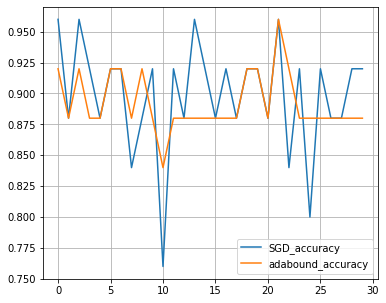

In [25]:
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(range(30),SGD_accuracy,label='SGD_accuracy'),ax.plot(range(30),adabound_accuracy,label='adabound_accuracy')
ax.legend()
ax.grid(True)

In [0]:

import os
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np

LABELS = ['SGD', 'AdaGrad', 'Adam', 'AMSGrad', 'AdaBound', 'AMSBound']